In [1]:
import numpy as np
from scipy.optimize import minimize, minimize_scalar
from scipy.linalg import norm
import matplotlib.pyplot as plt

We consider the problem of denoising the image $y$:

$$f(x)=\frac{1}{2}\|x-y\|^2+\frac{\lambda}{2}\|Dx\|^2.$$

Note we are now looking for an unknown $x$ which lives in a space of dimension $d=N_1 \times N_2$, the number of pixels of the image; for $N_1=N_2=512$, $d=512^2=262144$, hence the term 'large-scale optimization'.

Linear transform $D$ yields a vector of finite differences, i.e. $Dx = [x_2-x_1, x_3-x_2, ...]^T$ - 'discrete derivative'.

The size of the image is 512 x 512.


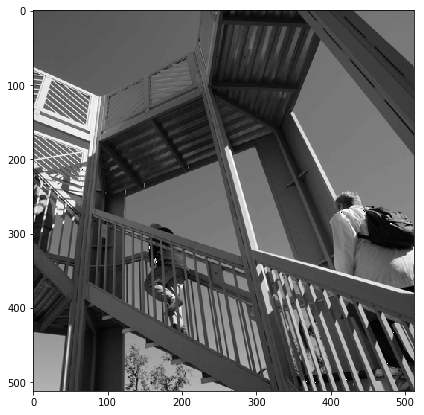

In [2]:
from scipy import misc
x = misc.ascent()
x = np.double(x)
print("The size of the image is %s x %s." % (x.shape[0],x.shape[1]))

plt.figure(figsize=(7,7))
plt.imshow(x, interpolation='nearest', cmap=plt.cm.gray, vmin=0, vmax=255)
plt.show()

In [3]:
(N1,N2) = x.shape
y = x + 20*np.random.randn(N1,N1)

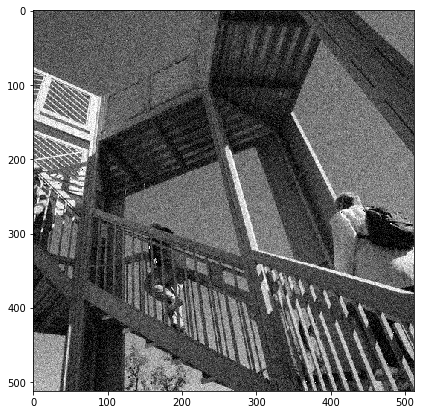

In [4]:
plt.figure(figsize=(7,7))
plt.imshow(y, interpolation='nearest', cmap=plt.cm.gray, vmin=0, vmax=255)
plt.show()

In [5]:
def D(x):
    vdiff = np.r_[np.diff(x,1,0), np.zeros([1,x.shape[1]])] # the r_ command concatenates along the rows
    hdiff = np.c_[np.diff(x,1,1), np.zeros([x.shape[0],1])] # the c_ command concatenates along the columns
    return np.concatenate((vdiff[...,np.newaxis], hdiff[...,np.newaxis]), axis=2) # combination along a third dimension

In [6]:
def Dadj(x):
    r = np.r_['0,2',-x[0,:,0],-np.diff(x[:-1,:,0],1,0),x[-2,:,0]]
    c = np.c_['1,2',-x[:,0,1],-np.diff(x[:,:-1,1],1,1),x[:,-2,1]]
    return r+c

$$\|D x\|^2 = \|\mathrm{vec}(V)\|^2 + \|\mathrm{vec}(H)\|^2$$
where 

$$\mathrm{vec}(V) = D_V \mathrm{vec}(X)$$
$$\mathrm{vec}(H) = D_H \mathrm{vec}(X)$$

or

$$\left[\begin{array}{c}\mathrm{vec}(V)\\\mathrm{vec}(H)\end{array}\right] = \left[\begin{array}{c}D_V\\D_H\end{array}\right] \mathrm{vec}(X)$$

and $\mathrm{vec}(X) = x$

$D = \left[\begin{array}{c}D_V\\D_H\end{array}\right]$, $D_V = \mathrm{I}_m \otimes D_n$, $D_H = D_m \otimes \mathrm{I}_n$, where $D_k = \left[ \begin{matrix}
-1 & 1 &0 && 0\\
0 & -1 & 1 && 0\\
0 && \ddots & \ddots &  \\
& && -1 &  1 \\
0 &  & 0&& 0  \end{matrix}  \right]$ is $k \times k$ matrix

The denoised image $\tilde{x}$ can be found in closed form:

$$\nabla f (\tilde{x})=0\ \Leftrightarrow\ \tilde{x}=(\mathrm{I}_d+\lambda D^TD)^{-1}y.$$

$$\nabla f(x) = x - y + \lambda D^TDx$$

In [7]:
print(np.sum(D(x)**2) - np.sum(x*Dadj(D(x))))

0.0


In [8]:
def f(x, y, Lambda, size):  
    return 0.5*norm(x - y)**2 + 0.5*Lambda*norm(D(x.reshape(size)))**2

def fgrad(x, y, Lambda, size):
    return x - y + Lambda*Dadj(D(x.reshape(size))).flatten()

Optimization terminated successfully.
         Current function value: 89498058.369121
         Iterations: 17
         Function evaluations: 18
         Gradient evaluations: 110
         Hessian evaluations: 0


Text(0.5, 1.0, 'Denoised image. Lambda = 2')

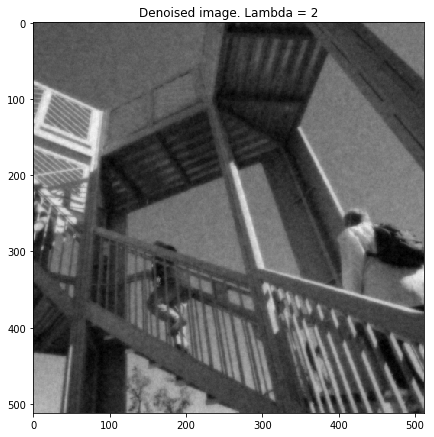

In [9]:
Lambda = 2 # small lambda
ff = lambda p: f(p, y.flatten(), Lambda, (N1,N2))
ffgrad = lambda p: fgrad(p, y.flatten(), Lambda, (N1,N2))

#x, steps = minimize_gd(ff, y.flatten(), ffgrad)
#x = x.reshape((N1,N2))

res = minimize(ff, y.flatten(), jac=ffgrad, method='Newton-CG', options={'disp': True})
x_denoised = res.x.reshape((N1,N2))

plt.figure(figsize=(7,7))
plt.imshow(x_denoised, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.subplots_adjust(top=3)
plt.title('Denoised image. Lambda = 2')


Optimization terminated successfully.
         Current function value: 153522881.927079
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 246
         Hessian evaluations: 0


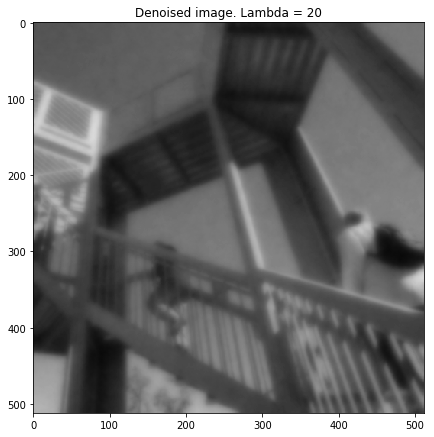

In [10]:
Lambda = 20 # large lambda
ff = lambda p: f(p, y.flatten(), Lambda, (N1,N2))
ffgrad = lambda p: fgrad(p, y.flatten(), Lambda, (N1,N2))

res = minimize(ff, y.flatten(), jac=ffgrad, method='Newton-CG', options={'disp': True})
x_denoised2 = res.x.reshape((N1,N2))

plt.figure(figsize=(7,7))
plt.imshow(x_denoised2, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.subplots_adjust(top=3)
plt.title('Denoised image. Lambda = 20')
plt.show()